<a href="https://colab.research.google.com/github/aydawudu/ML_with_PyTorch_and_Sklearn/blob/main/Regression_Analysis__ML_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preparations

In [1]:
import pandas as pd


columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
           'Central Air', 'Total Bsmt SF', 'SalePrice']

df = pd.read_csv('http://jse.amstat.org/v19n3/decock/AmesHousing.txt',
                 sep='\t',
                 usecols=columns)

df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [2]:
df.shape

(2930, 6)

In [3]:
#encode the central air feature
df['Central Air']=df['Central Air'].map({'N':0, 'Y':1})

In [4]:
#find missing values
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [5]:
#remove rows with missing values
df=df.dropna(axis=0)
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

### Visualizing the important characteristics of a dataset


In [6]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

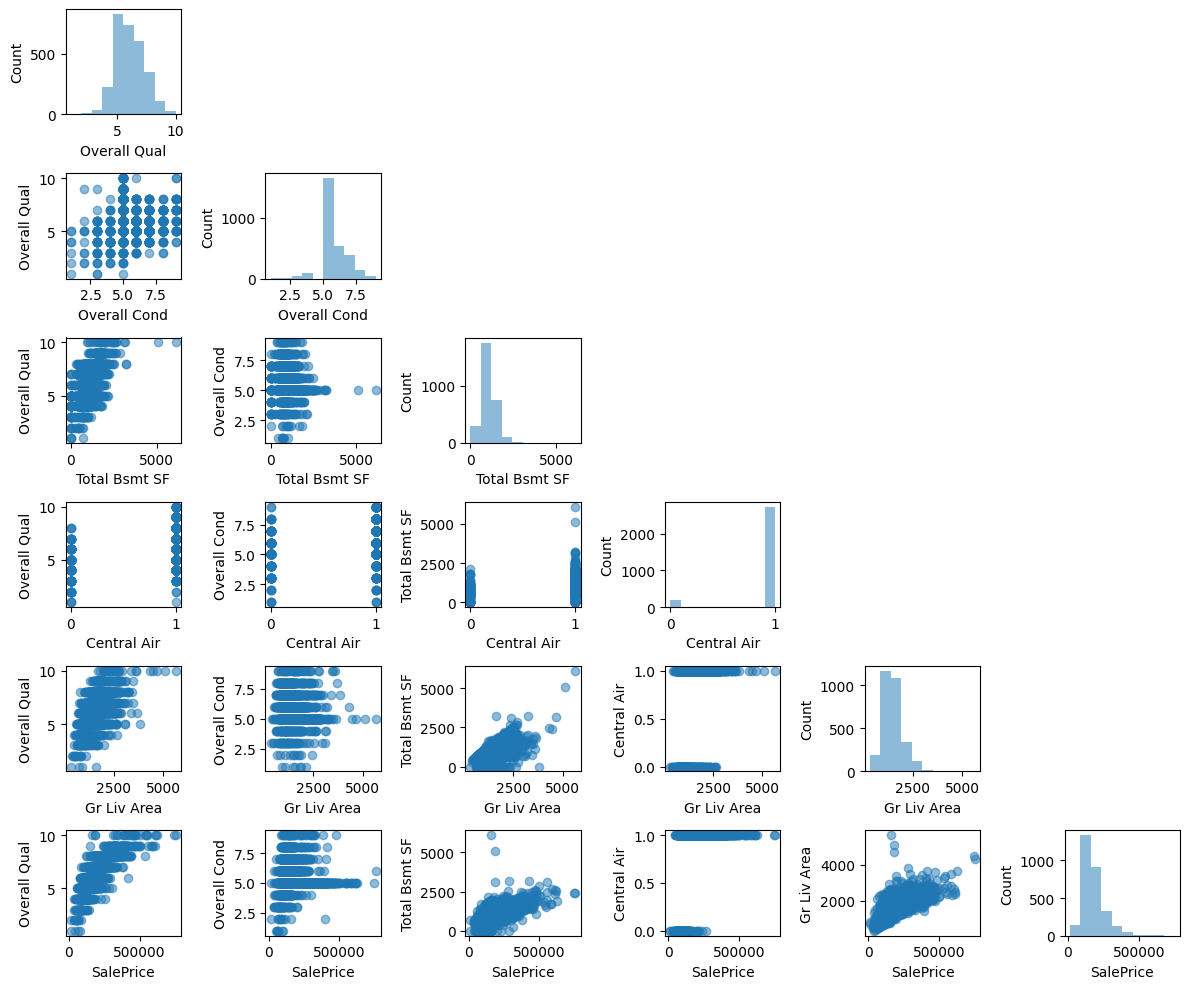

In [7]:
scatterplotmatrix(df.values, figsize=(12, 10), names=df.columns, alpha=0.5)
plt.tight_layout()
plt.show()

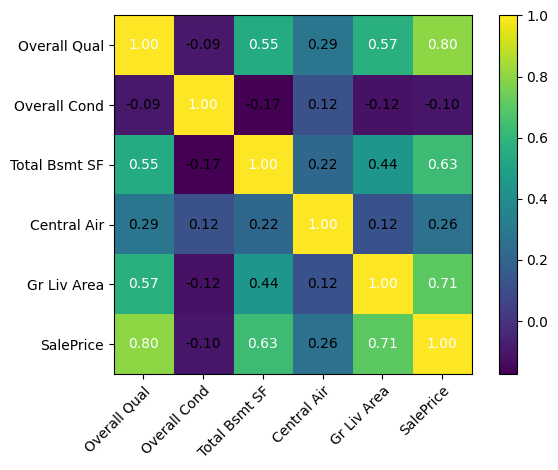

In [8]:
import numpy as np
from mlxtend.plotting import heatmap

cm =np.corrcoef(df.values.T)
hm=heatmap(cm, row_names=df.columns, column_names=df.columns)
plt.tight_layout()
plt.show()

## mplementing an ordinary least squares linear regression model
...

### Solving regression for regression parameters with gradient descent

In [9]:
class LinearRegressionGD:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.array([0.])
        self.losses_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        return self.net_input(X)

In [10]:
X=df[['Gr Liv Area']].values
y=df['SalePrice'].values

In [11]:
#standardize and fit
from sklearn.preprocessing import StandardScaler

sc_x= StandardScaler()
sc_y=StandardScaler()
X_std =sc_x.fit_transform(X)
y_std=sc_y.fit_transform(y[:, np.newaxis]).flatten() #scikit kearb expect 2-D aaray so we use np.newaxis to add a new dimention then use flatten( to convert it back )

In [12]:
lr=LinearRegressionGD(eta=0.1)
lr.fit(X_std, y_std)

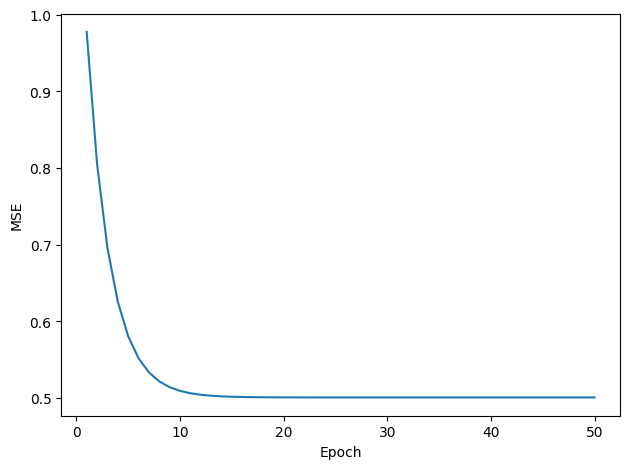

In [13]:
#plot the loss function
plt.plot(range(1, lr.n_iter+1), lr.losses_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

In [14]:
#plot regression line on scatter plot
def lin_regplot(X, y, model):
  plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
  plt.plot(X, model.predict(X), color='black', lw=2)
  return

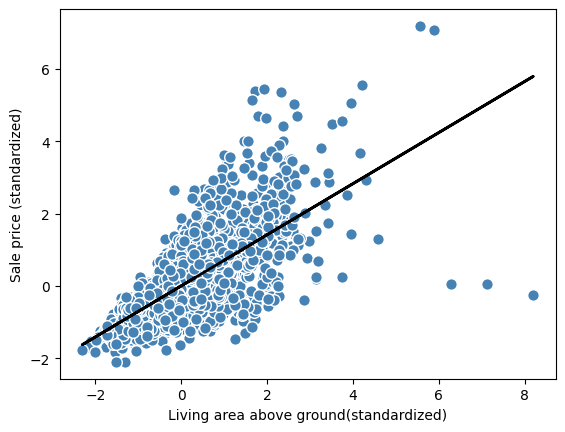

In [15]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Living area above ground(standardized)')
plt.ylabel('Sale price (standardized)')
plt.show()

In [16]:
#scale back predicted outcome variables using inverse_transform
feature_std=sc_x.transform(np.array([[2500]]))
target_std=lr.predict(feature_std)
target_reverted=sc_y.inverse_transform(target_std.reshape(-1, 1))
print(f'Sale price" ${target_reverted.flatten()[0]:.2f}')

Sale price" $292507.07


In [17]:
print(f'Slope:{lr.w_[0]:.3f}')
print(f'Intercept: {lr.b_[0]:.3f}')

Slope:0.707
Intercept: -0.000


### Estimating the coefficient of a regression model via scikit-learn

In [18]:
#using scikit-learn with unstandardized variables
from sklearn.linear_model import LinearRegression

In [19]:
slr=LinearRegression()
slr.fit(X, y)
y_pred=slr.predict(X)
print(f'Slope: {slr.coef_[0]:.3f}')
print(f'Intercept: {slr.intercept_:.3f}')

Slope: 111.666
Intercept: 13342.979


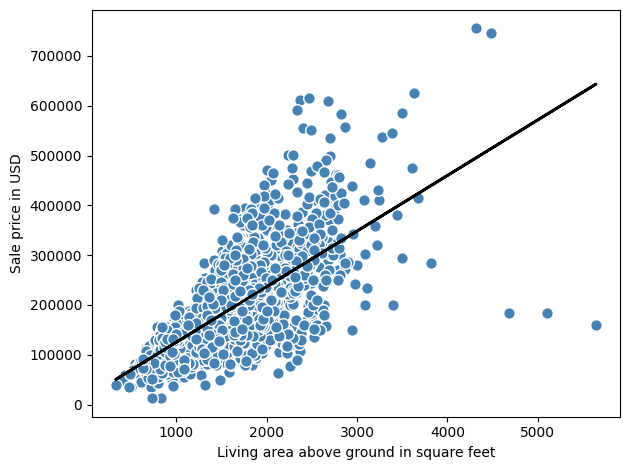

In [20]:
#visualize
lin_regplot(X, y, slr)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in USD')
plt.tight_layout()
plt.show()

Normal Equations alternative:

In [21]:
# adding a column vector of "ones"
Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))

print(f'Slope: {w[1]:.3f}')
print(f'Intercept: {w[0]:.3f}')

Slope: 111.666
Intercept: 13342.979


## Fitting a robust regression model using RANSAC


In [22]:
#fits a regression model to a subset of data (inliers) in order to handle outliers effect
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100, # default
                         min_samples=0.95,
                         loss='absolute_error', # default
                         residual_threshold=None, # default is median absolute deviation(MAD)
                         random_state=123)


ransac.fit(X, y)

RANSACRegressor(estimator=LinearRegression(), min_samples=0.95,
                random_state=123)

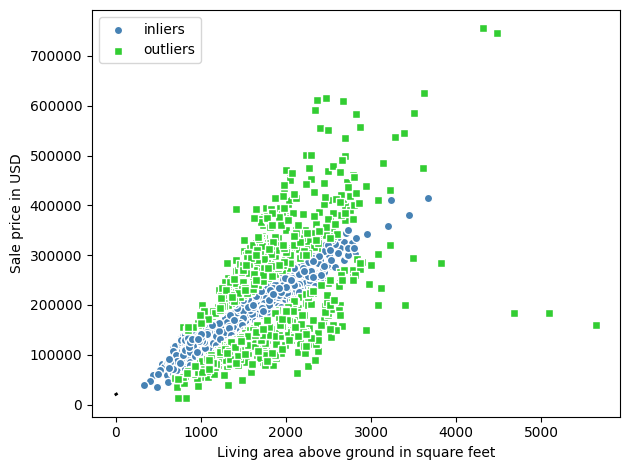

In [23]:
#obtain inliers and outliers
inlier_mask=ransac.inlier_mask_
outlier_mask=np.logical_not(inlier_mask)

line_X=np.arange(3, 10, 1)
line_y_ransac=ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white',
            marker='o', label='inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolors='white',
            marker='s', label='outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2 )
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in USD')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [24]:
print(f'Slope: {ransac.estimator_.coef_[0]:.3f}')
print(f'Intercept : {ransac.estimator_.intercept_:.3f}')

Slope: 106.348
Intercept : 20190.093


In [25]:
#obtain the median absolute deviation (MAD)
def median_absolute_deviation(data):
  return np.median(np.abs(data - np.median(data)))

median_absolute_deviation(y)

37000.0

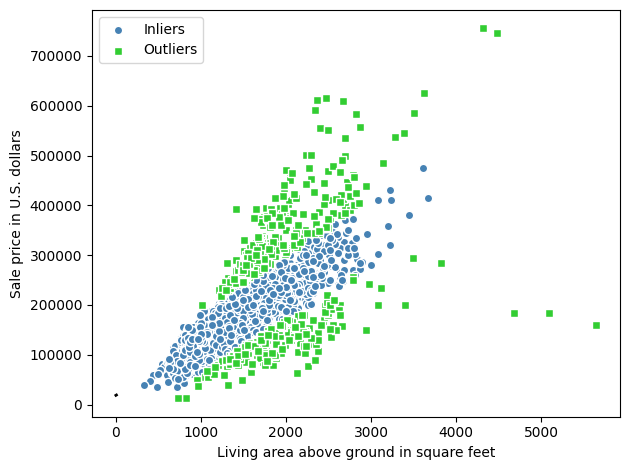

In [26]:
#reducing the outliers data point
ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100, # default
                         min_samples=0.95,
                         loss='absolute_error', # default
                         residual_threshold=65000, # choose residual threshold greater than MAD to reduce the outlier data point
                         random_state=123)

ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white',
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white',
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/09_10.png', dpi=300)
plt.show()

## Evaluating the performance of linear regression models

In [27]:
# split into train and test then create a multiple regression
from sklearn.model_selection import train_test_split

target='SalePrice'
features=df.columns[df.columns != target]

X=df[features].values
y=df[target].values

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=123)

In [28]:
slr=LinearRegression()

slr.fit(X_train, y_train)
y_train_pred=slr.predict(X_train)
y_test_pred=slr.predict(X_test)

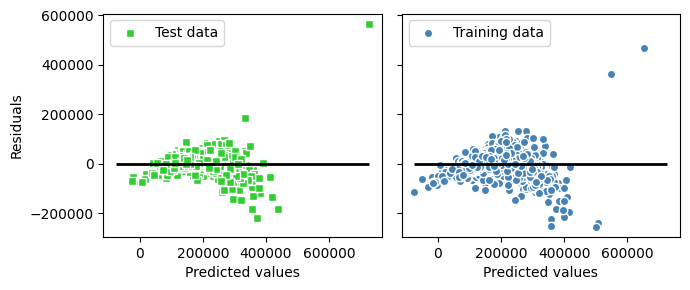

In [29]:
#Residual plots since this is multiple feature regression
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min= np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white', label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white', label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
  ax.set_xlabel('Predicted values')
  ax.legend(loc='upper left')
  ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()
plt.show()

In [30]:
#MSE normalized according to sample size so can be compared accross different sample size
from sklearn.metrics import mean_squared_error

mse_train =mean_squared_error(y_train, y_train_pred)
mse_test =mean_squared_error(y_test, y_test_pred)
print(f'MSE train: {mse_train:.2f}')
print(f'MSE test: {mse_test:.2f}')

MSE train: 1497216245.85
MSE test: 1516565821.00


In [31]:
#MAE to show the square root of MSE (more intuitive)
from sklearn.metrics import mean_absolute_error

mae_train=mean_absolute_error(y_train, y_train_pred)
mae_test=mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')

MAE train: 25983.03
MAE test: 24921.29


In [32]:
#R2
from sklearn.metrics import r2_score
r2_train=r2_score(y_train, y_train_pred)
r2_test=r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

R^2 train: 0.77
R^2 test: 0.75


### Using regularized methods for regression

Regularization is done to reduce complexity thereby tackling overfitting;
Types:
- Ridge (L1): Shrinks the weights of the model
- LASSO (L2):  Can make certains weights zero
- Elastic net: Compromise between L1 and L2 where L1 is used to generate sparsity and L2 to select more than n features

In [33]:
from sklearn.linear_model import Lasso

lasso =Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
y_train_pred=lasso.predict(X_train)
y_test_pred=lasso.predict(X_test)
print(lasso.coef_)

[26251.38276394   804.70816337    41.94651964 11364.80761309
    55.67855548]


In [34]:
train_mse =mean_squared_error(y_train, y_train_pred)
test_mse=mean_squared_error(y_test, y_test_pred)
print(f'MSE train: {train_mse:.3f}, test:{test_mse:.3f}')

train_r2=r2_score(y_train, y_train_pred)
test_r2=r2_score(y_test, y_test_pred)
print(f'R^2 train: {train_r2:.3f}, {test_r2:.3f}')

MSE train: 1497216262.014, test:1516576825.348
R^2 train: 0.769, 0.752


In [35]:
#How to initizlize Ridge regression:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)

In [36]:
#How to initizlize LASSO regression
from sklearn.linear_model import Lasso
lasso=Lasso(alpha=1.0)

In [37]:
#How to initialize
from sklearn.linear_model import ElasticNet

elanet=ElasticNet(alpha=1.0, l1_ratio=0.5)

### Turning a linear regression model into a curve - polynomial regression

In [38]:
#with sample toy
X = np.array([258.0, 270.0, 294.0,
              320.0, 342.0, 368.0,
              396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]

y = np.array([236.4, 234.4, 252.8,
              298.6, 314.2, 342.2,
              360.8, 368.0, 391.2,
              390.8])

In [39]:
from sklearn.preprocessing import PolynomialFeatures

lr=LinearRegression()
pr=LinearRegression()
quadratic=PolynomialFeatures(degree=2)
X_quad=quadratic.fit_transform(X)

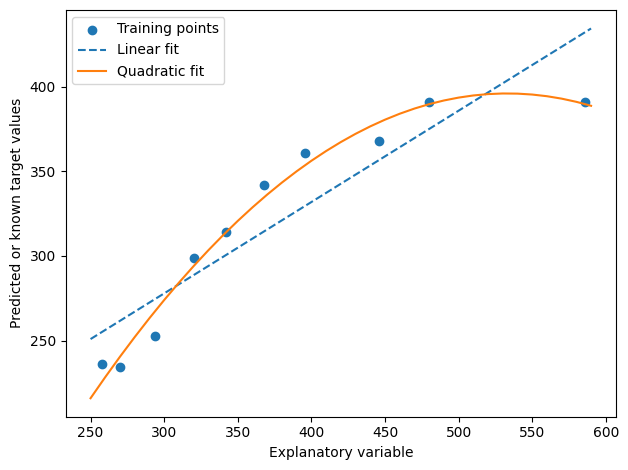

In [40]:
#fit linear features
lr.fit(X, y)
X_fit=np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

#fit quadratic features
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

#plot results
plt.scatter(X, y, label='Training points')
plt.plot(X_fit, y_lin_fit, label='Linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='Quadratic fit')
plt.xlabel('Explanatory variable')
plt.ylabel('Predicted or known target values')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [41]:
#compute evaluation on the toy data model
y_lin_pred=lr.predict(X)
y_quad_pred=pr.predict(X_quad)

In [42]:
mse_lin=mean_squared_error(y, y_lin_pred)
mse_quad=mean_squared_error(y, y_quad_pred)
print(f'Training MSE LINEAR: {mse_lin:.3f}'
      f', quadratic: {mse_quad:.3f}')

r2_lin=r2_score(y, y_lin_pred)
r2_quad=r2_score(y, y_quad_pred)
print(f'Traning R^2 linear:{r2_lin:.3f}'
      f', quadratic: {r2_quad:.3f}')

Training MSE LINEAR: 569.780, quadratic: 61.330
Traning R^2 linear:0.832, quadratic: 0.982


### Modeling nonlinear relationships in the Ames Housing dataset

In [44]:
X = df[['Gr Liv Area']].values
y=df['SalePrice'].values

#remove the outliers
X=X[(df['Gr Liv Area'] < 4000 )]
y=y[(df['Gr Liv Area'] < 4000)]

regr=LinearRegression()

#create quadratic features
quadratic =PolynomialFeatures(degree=2)
cubic=PolynomialFeatures(degree=3)
X_quad=quadratic.fit_transform(X)
X_cubic=cubic.fit_transform(X)

#fit features
X_fit=np.arange(X.min()-1, X.max()+2, 1)[:, np.newaxis]

regr=regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2=r2_score(y, regr.predict(X))

regr=regr.fit(X_quad, y)
y_quad_fit=regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2=r2_score(y, regr.predict(X_quad))

regr= regr.fit(X_cubic, y)
y_cubic_fit=regr.predict(cubic.fit_transform(X_fit))
cubic_r2 =r2_score(y, regr.predict(X_cubic))

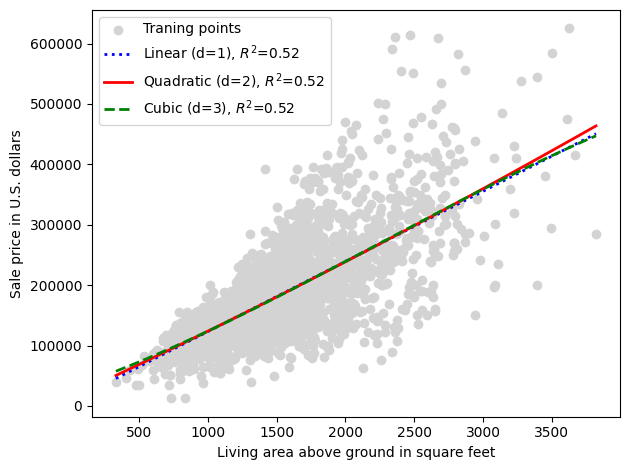

In [45]:
#plot results
plt.scatter(X, y, label='Traning points', color='lightgray')
plt.plot(X_fit, y_lin_fit, label=f'Linear (d=1), $R^2$={linear_r2:.2f}',
         color='blue',
         lw=2,
         linestyle=':')

plt.plot(X_fit, y_quad_fit,
         label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}',
         color='red',
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit,
         label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
         color='green',
         lw=2,
         linestyle='--')

plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/09_13.png', dpi=300)
plt.show()

The quadratic and cubic features shows little effect because relationships between liv area and sale price is linear.

Let's try with another feature

In [46]:
X =df[['Overall Qual']].values
y=df['SalePrice'].values

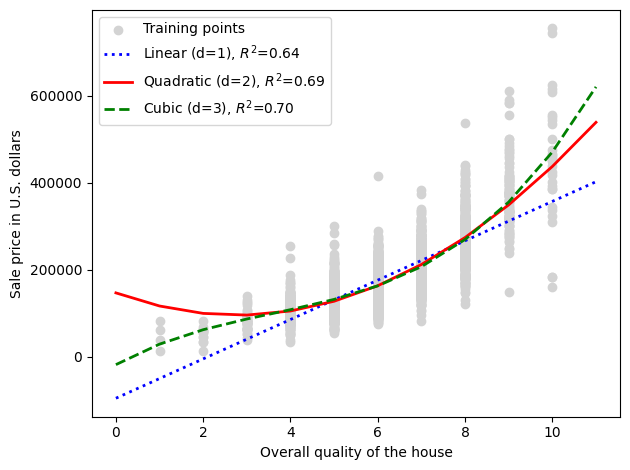

In [47]:
regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min()-1, X.max()+2, 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='Training points', color='lightgray')

plt.plot(X_fit, y_lin_fit,
         label=f'Linear (d=1), $R^2$={linear_r2:.2f}',
         color='blue',
         lw=2,
         linestyle=':')

plt.plot(X_fit, y_quad_fit,
         label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}',
         color='red',
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit,
         label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
         color='green',
         lw=2,
         linestyle='--')


plt.xlabel('Overall quality of the house')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/09_14.png', dpi=300)
plt.show()

The quadratic and cubic fit capture the relationship between sales price and overall quality of the house better than the linear fit

## Dealing with nonlinear relationships using random forests

### Decision tree regression

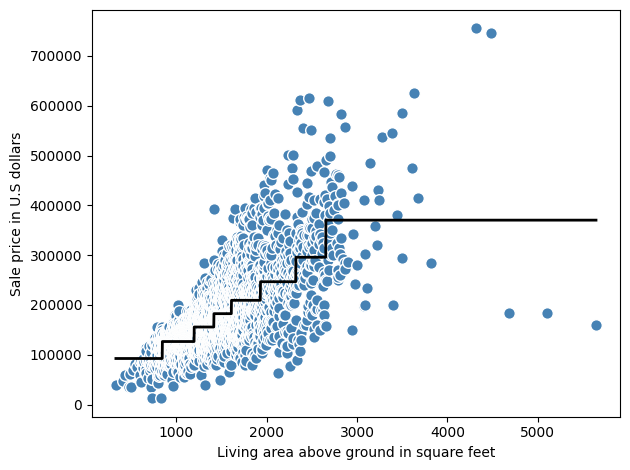

In [50]:
from sklearn.tree import DecisionTreeRegressor

X=df[['Gr Liv Area']].values
y=df['SalePrice'].values

tree=DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx =X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S dollars')

plt.tight_layout()
plt.show()

In [51]:
tree_r2 = r2_score(y, tree.predict(X))
tree_r2

0.5144569334885711

### Random forest regression

In [52]:
target='SalePrice'
features = df.columns[df.columns != target]

X=df[features].values
y=df[target].values

X_train, X_test, y_train, y_test=train_test_split( X, y, test_size=0.3, random_state=123)

In [53]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000,
                               criterion='squared_error',
                               random_state=1,
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred=forest.predict(X_train)
y_test_pred=forest.predict(X_test)

mae_train =mean_absolute_error(y_train, y_train_pred)
mae_test=mean_absolute_error(y_test, y_test_pred)
print(f'MAE train : {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')

r2_train = r2_score(y_train, y_train_pred)
r2_test =r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

MAE train : 8305.18
MAE test: 20821.77
R^2 train: 0.98
R^2 test: 0.85


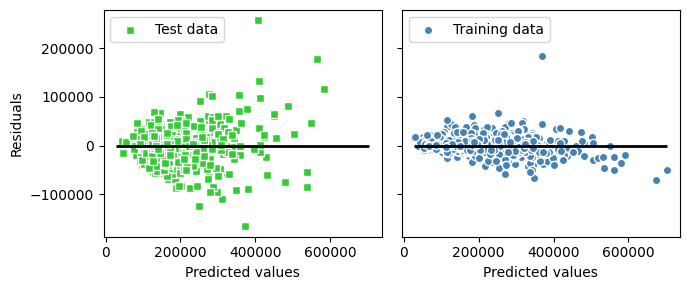

In [54]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()

#plt.savefig('figures/09_16.png', dpi=300)
plt.show()